In [1]:
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.2.1


# Problem 5

## Generate data

In [2]:
d = 35
n_train, n_val, n_test = 300, 60, 30
np.random.seed(0)
beta = np.random.randn(d)
beta_true = beta / np.linalg.norm(beta)
# Generate and fix training data
X_train = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_train)])
Y_train = X_train @ beta_true + np.random.normal(loc = 0.0, scale = 0.5, size = n_train)
# Generate and fix validation data (for tuning lambda). 
X_val = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_val)])
Y_val = X_val @ beta_true 
# Generate and fix test data
X_test = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_test)])
Y_test = X_test @ beta_true

## Solve the problem

In [3]:
def tilde_op(W, X):
    return torch.nn.functional.relu(W @ X.T).T

def compute_theta_opt(W, X, Y, lambda_, p):
    X_tilde = tilde_op(W, X)
    return torch.linalg.solve(X_tilde.T @ X_tilde + lambda_ * torch.eye(p), X_tilde.T @ Y)
    # return torch.linalg.inv(X_tilde.T @ X_tilde + lambda_ * torch.eye(p)) @ X_tilde.T @ Y

def loss(W, X, Y, theta, lambda_):
    # return (sum([1/2 * torch.square(theta.T@torch.nn.functional.relu(W @ X[i])-Y[i]) for i in range(len(Y))]) 
    #         + lambda_/2 * torch.square(torch.linalg.norm(theta)))  # original loss function given
    # return (1/2 * torch.square(torch.linalg.norm(tilde_op(W, X) @ theta - Y))
    #        + lambda_/2 * torch.square(torch.linalg.norm(theta)))  # equivalent loss function
    return torch.linalg.norm(tilde_op(W, X) @ theta - Y)

In [4]:
lambda_list = [2 ** i for i in range(-6, 6)]
num_params =  np.arange(1, 1501, 10)  # np.arange(1, 21, 10)

errors_opt_lambda = []
errors_fixed_lambda = []
for p in num_params:
    print(f"On parameter: {p:04}", end='\r')
    
    W = torch.normal(0, np.sqrt(1/p), size=(p, d))
    # W = torch.zeros((p, d))
    # torch.nn.init.normal_(W, mean=0, std=np.sqrt(1/p))
    
    theta_opt = compute_theta_opt(W, X_train, Y_train, 0.01, p)
    errors_fixed_lambda.append(loss(W, X_test, Y_test, theta_opt, 0.01))
    
    loss_per_lambda = {}
    theta_per_lambda = {}
    for lambda_ in lambda_list:
        theta_opt = compute_theta_opt(W, X_train, Y_train, lambda_, p)
        theta_per_lambda[lambda_] = theta_opt
        loss_per_lambda[lambda_] = loss(W, X_val, Y_val, theta_opt, lambda_)
    lambda_opt = min(loss_per_lambda, key=loss_per_lambda.get)
    theta_opt = theta_per_lambda[lambda_opt]
    errors_opt_lambda.append(loss(W, X_test, Y_test, theta_opt, lambda_opt))

# errors_opt_lambda = [1] * len(num_params)
print('Done.               ')

Done.               


## Plot results

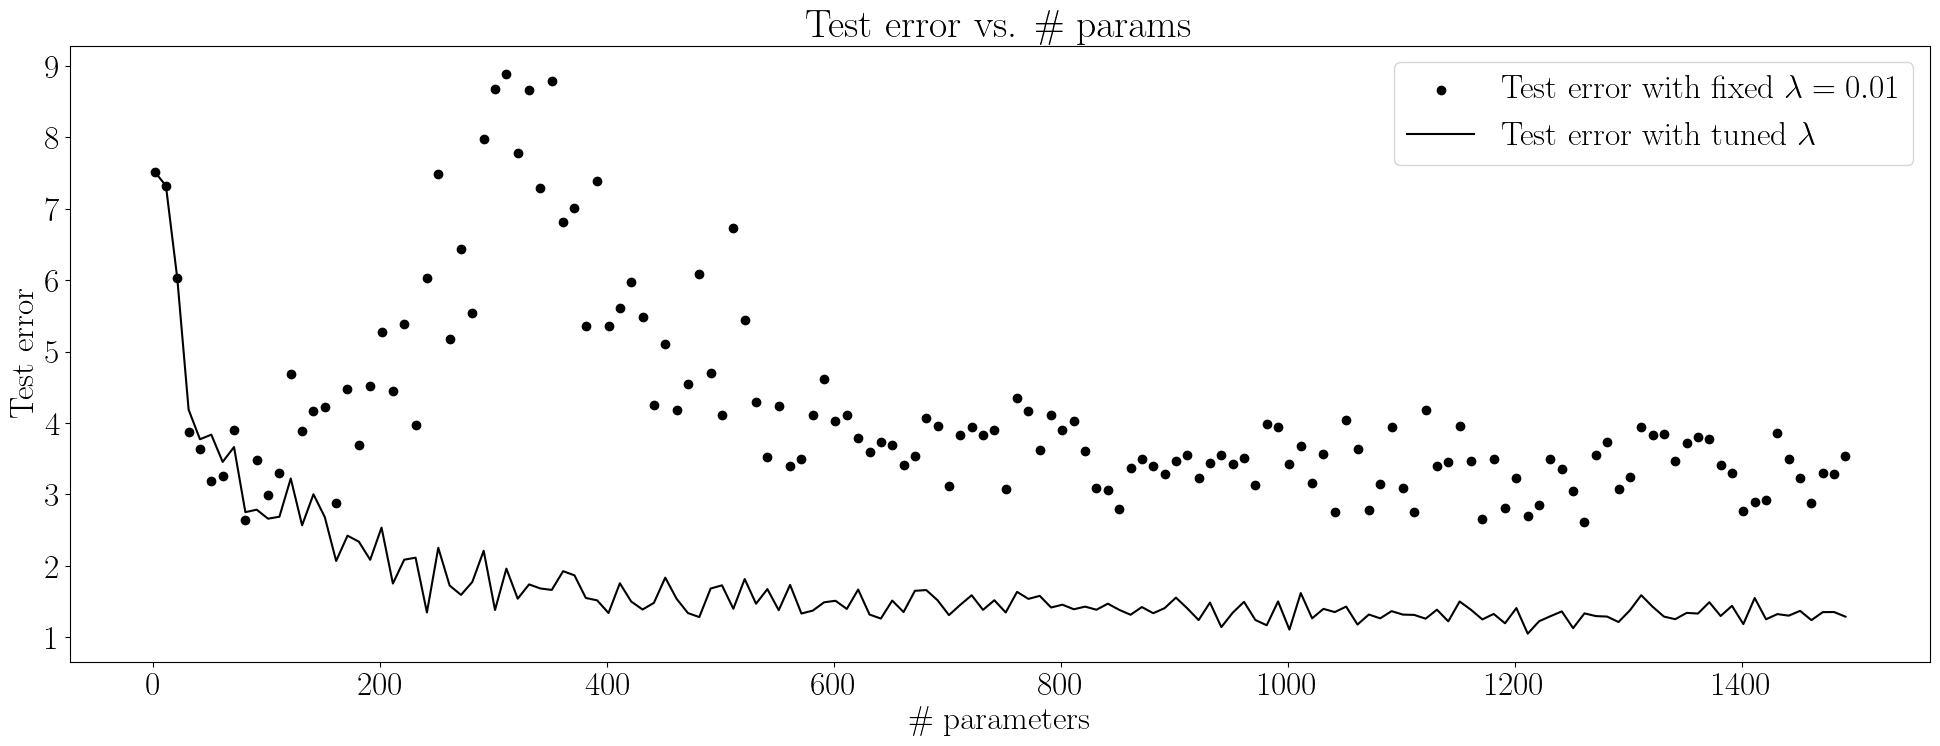

In [5]:
plt.figure(figsize = (24, 8))
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rc('font', size = 24)


plt.scatter(num_params, errors_fixed_lambda, color = 'black',
            label = r"Test error with fixed $\lambda = 0.01$",
            ) 
plt.legend()

plt.plot(num_params, errors_opt_lambda, 'k', label = r"Test error with tuned $\lambda$")
plt.legend()
plt.xlabel(r'$\#$ parameters')
plt.ylabel('Test error')
plt.title(r'Test error vs. $\#$ params')

plt.show()